# Download elevation model variables

Download elevation raster layer covering your study area envelope, including:

- Elevation from the SRTM (available from the [earthaccess API](https://github.com/nsidc/earthaccess/))
- Elsa video
    - [Shuttle Radar Topology Mission (SRTM)](https://cuboulder.zoom.us/rec/play/6fTikKcJPbGPB321iHmAa3dhMUR7r0n_zSZ3XxjL-SfBLpVfsrZJ1CrHlkOrK6jvTlYgztvvskfvaAGP.T6ixGvWj42gYShMV?canPlayFromShare=true&from=share_recording_detail&continueMode=true&componentName=rec-play&originRequestUrl=https%3A%2F%2Fcuboulder.zoom.us%2Frec%2Fshare%2FploG3HVb_qA0QU8eACIHMKtNbkiGFys7cmiBbTRryv3NUWBmKo-DXhzXdU3cbpz7.99x0PeiCHONSj6Ty)



In [1]:
pip install --quiet ~/Documents/GitHub/landmapy

Note: you may need to restart the kernel to use updated packages.


In [2]:
from landmapy.habitat import create_data_dir, merge_soil, maca_year, process_maca
from landmapy.index import redline_over_index

import rioxarray as rxr

More packages for slope and aspect

In [3]:
import earthaccess
import xrspatial
import rioxarray as rxr
import rioxarray.merge as rxrmerge

import os
from glob import glob

/Users/brianyandell/miniconda3/envs/earth-analytics-python/lib/python3.11/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
data_dir = create_data_dir('habitat')
data_dir

'/Users/brianyandell/earth-analytics/data/habitat'

In [5]:
%store -r buffalo_gdf
print(buffalo_gdf.total_bounds)
#buffalo_gdf.plot()

[-104.05473027   42.74093601 -101.47233564   43.99459902]


In [41]:
buffalo_gdf

,OBJECTID,NATIONALGRASSLANDID,GRASSLANDNAME,GIS_ACRES,SHAPEAREA,SHAPELEN,geometry
12,185977,295518010328,Buffalo Gap National Grassland,654877.177,0.295196,33.006274,"MULTIPOLYGON (((-102.3384 43.93679, -102.33339..."
15,185980,295521010328,Oglala National Grassland,215804.927,0.096279,1.970612,"POLYGON ((-103.72478 43.001, -103.725 43.001, ..."


In [7]:
buffalo_gdf['color'] = ['white','red']

In [8]:
buffalo_gdf['color'].values[0]

'white'

## Slope and Aspect

In [14]:
project_dir = create_data_dir('habitat')
elevation_dir = create_data_dir('habitat/srtm')
elevation_dir

'/Users/brianyandell/earth-analytics/data/habitat/srtm'

In [5]:
earthaccess.login()

In [12]:
datasets = earthaccess.search_datasets(keyword='SRTM DEM', count=11)
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle']) # want 'umn'
# want SRTMGL1? 1 arc second = 30m (also, 3, 30 arc second)

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002


In [15]:
%store -r buffalo_gdf
bounds = tuple(buffalo_gdf.total_bounds)
bounds

(np.float64(-104.05473026929808),
 np.float64(42.74093600852109),
 np.float64(-101.47233563761043),
 np.float64(43.99459902288785))

Note label as `hgt` and files are zipped.
Choice of opening or download. We will download

In [19]:
glob(os.path.join(elevation_dir, '*.hgt.zip'))

['/Users/brianyandell/earth-analytics/data/habitat/srtm/N42W102.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N43W102.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N43W105.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N42W105.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N43W104.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N42W104.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N42W103.SRTMGL1.hgt.zip',
 '/Users/brianyandell/earth-analytics/data/habitat/srtm/N43W103.SRTMGL1.hgt.zip']

In [23]:
# This gets list of granules. Only need to do once.
srtm_pattern = os.path.join(elevation_dir, '*.hgt.zip')
if(not glob(srtm_pattern)):
    srtm_results = earthaccess.search_data(
        short_name = 'SRTMGL1',
        bounding_box = bounds
    )
    srtm_results = earthaccess.download(srtm_results, elevation_dir)

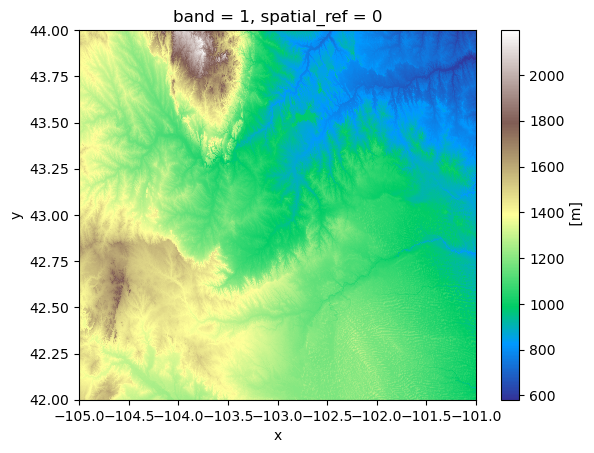

In [32]:
srtm_da_list = []
for srtm_path in glob(srtm_pattern):
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
    srtm_da_list.append(tile_da)

srtm_da = rxrmerge.merge_arrays(srtm_da_list)
srtm_da.plot(cmap='terrain')

In [ ]:
redline_over_index(buffalo_gdf, srtm_da, edgecolor="white", cmap='terrain')